# HW4: K-Means Clustering in Python
# ----
#### Mason Ware
#### COSI 101a, Brandeis University (Spring 2022)

a.) Per the instructions of the assingment, I will be doing k-means clustering in Python to execute clustering on the given data set located at `./hw4.csv`. The k-means algorithm I will be using is the one provided by the sklearn module in python, `KMeans`. 

### CUSTOM CODE

In [1]:
import numpy as np
from numpy.linalg import norm


class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        for _ in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
    
    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)

### Necessary Packages:

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets import (make_blobs,
                              make_circles,
                              make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')



### Loading and Reading Data

In [5]:
df = pd.read_csv('data/hw4.csv', header = None)
df = df.T

sample_arrays = {}

#make a dict of sample runs to 2d arrays of their results
for i in range(4999):
    array_1d = np.array(list(df[i]))
    array_2d = np.reshape(array_1d[:94], (47,2))
    sample_arrays[i] = array_2d

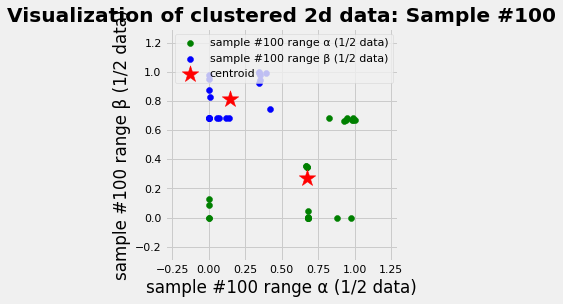

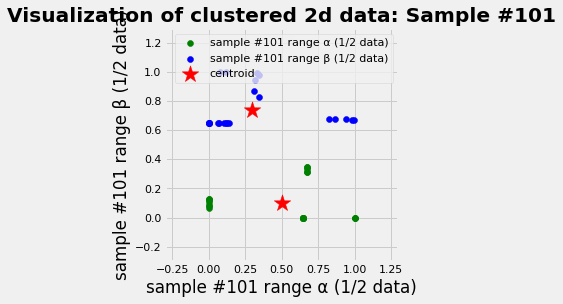

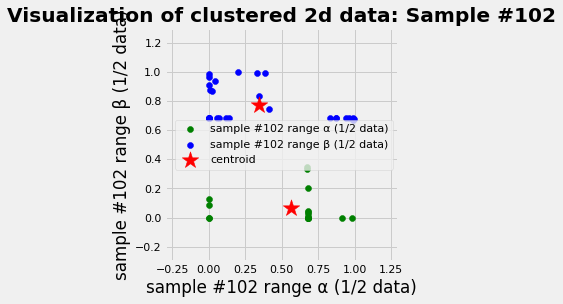

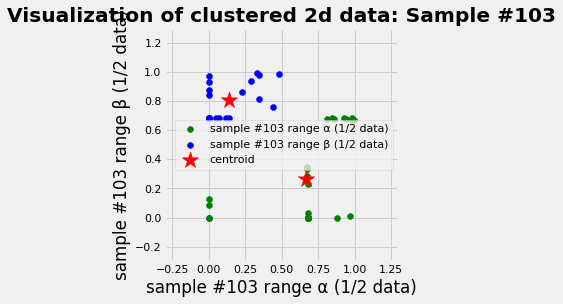

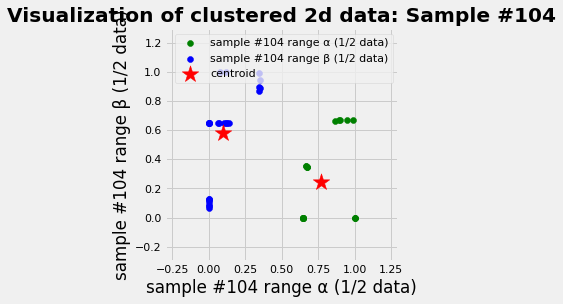

In [37]:
for i in range(100, 105):
    # X_std = StandardScaler().fit_transform(sample_arrays[i])

    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2, max_iter=100)
    km.fit(sample_arrays[i])
    centroids = km.centroids

    
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(sample_arrays[i][km.labels == 0, 0], sample_arrays[i][km.labels == 0, 1],
                c='green', label=f'sample #{i} range α (1/2 data)')
    plt.scatter(sample_arrays[i][km.labels == 1, 0], sample_arrays[i][km.labels == 1, 1],
                c='blue', label=f'sample #{i} range β (1/2 data)')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
                c='r', label='centroid')

    plt.legend()
    plt.xlim([-0.3, 1.3])
    plt.ylim([-0.3, 1.3])
    plt.xlabel(f'sample #{i} range α (1/2 data)')
    plt.ylabel(f'sample #{i} range β (1/2 data)')
    plt.title(f'Visualization of clustered 2d data: Sample #{i}', fontweight='bold')
    ax.set_aspect('equal');


Next, we’ll show that different initializations of centroids may yield different results. I’ll use 9 different random_state(s) to change the initialization of the centroids and plot the results. The title of each plot will be the sum of the squared distance of each initialization.

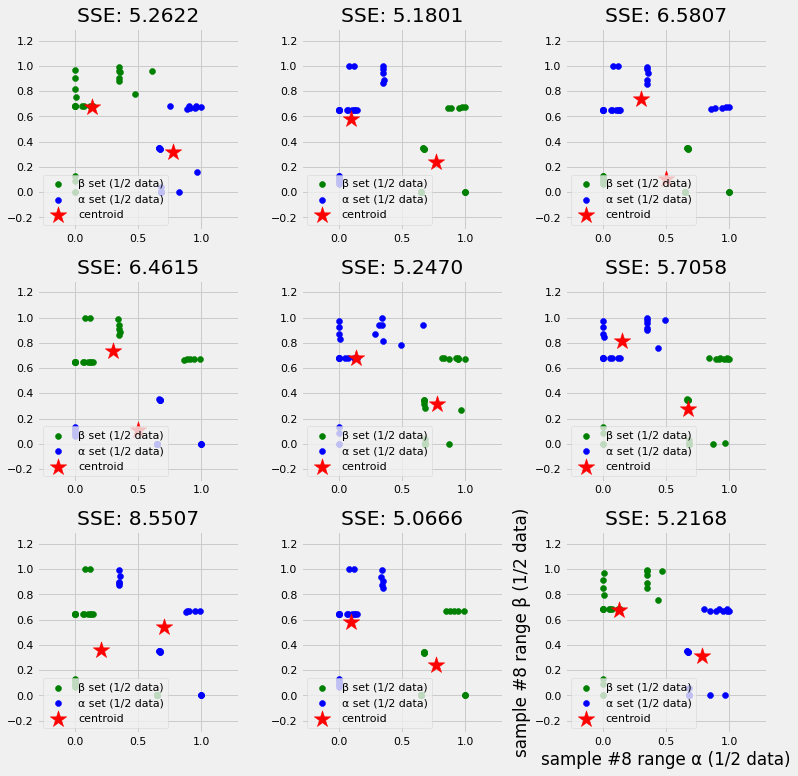

In [51]:
n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(11, 11))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    
    # run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(sample_arrays[i])
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(sample_arrays[i][km.labels == 0, 0], sample_arrays[i][km.labels == 0, 1],
                  c='green', label='β set (1/2 data)')
    ax[i].scatter(sample_arrays[i][km.labels == 1, 0], sample_arrays[i][km.labels == 1, 1],
                  c='blue', label=f'α set (1/2 data)')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].set_xlim([-0.3, 1.3])
    ax[i].set_ylim([-0.3, 1.3])
    ax[i].legend(loc='lower left')
    ax[i].set_title(f'SSE: {km.error:.4f}')
    plt.xlabel(f'sample #{i} range α (1/2 data)')
    plt.ylabel(f'sample #{i} range β (1/2 data)')
    ax[i].set_aspect('equal')
plt.tight_layout();

As the graphs above show that we only ended up with two different ways of clusterings based on different initializations, we would pick the one with the lowest sum of squared distance.

The rlbow method gives us an idea on what a good k number of clusters would be based on the sum of squared euclidian distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where the SSE starts to flatten out and resemble an elbow.

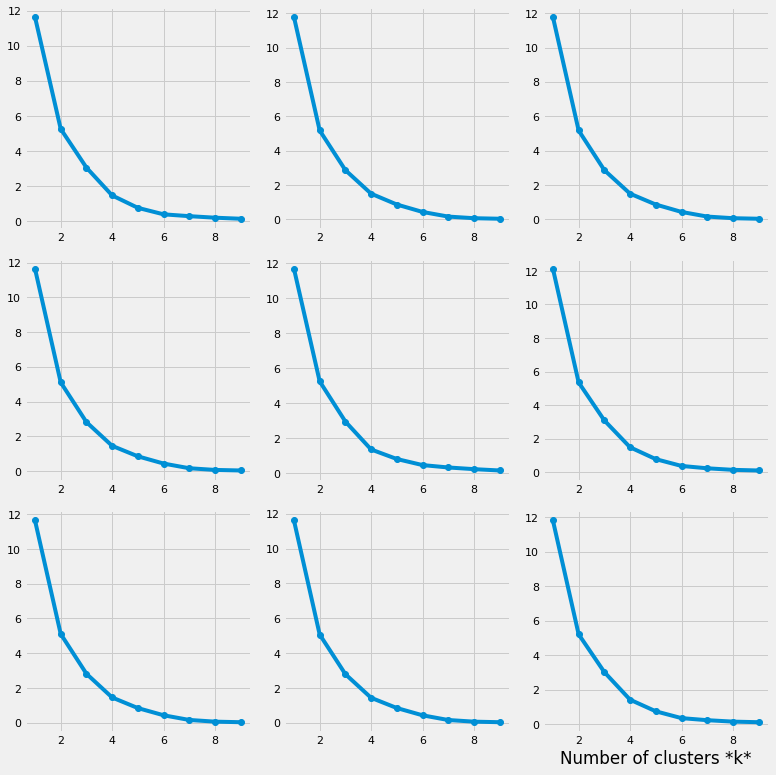

In [50]:
# Run the Kmeans algorithm and get the index of data points clusters
fig, ax = plt.subplots(3, 3, figsize=(11, 11))
ax = np.ravel(ax)
for i in range(n_iter):
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k)
        km.fit(sample_arrays[i])
        sse.append(km.inertia_)

    # Plot sse against k
    ax[i].plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters *k*')
plt.tight_layout();